# Symbolic FE (Gram) algorithm

In [56]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy
from mpmath import *

mp.dps = 50
eps = 1e-50

mpf(1) / 6

mpf('0.16666666666666666666666666666666666666666666666666656')

### Step 1: Obtain orthonormal bases of Gram polynomials on the boundaries

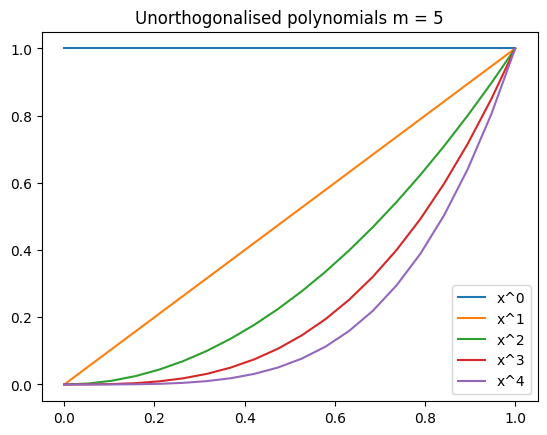

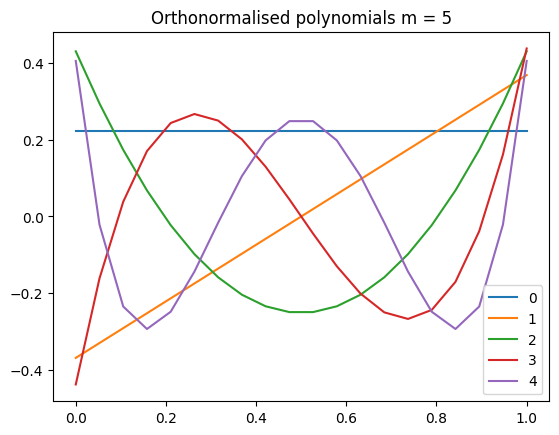

The orthonormalised polynomials and their scalar products
i = 0 u_ij = [1.0  9.6184032609648870233333172421786367911837203578419e-52  -4.7064808189575757861747494078233329541326165634489e-51  2.3831228273769312314122937477708622418544518789527e-50  6.4714111260666667059902804357570828119323477747422e-51]
i = 1 u_ij = [9.6184032609648870233333172421786367911837203578419e-52  1.0  9.7074488175920378606020910718683366317682979096207e-52  -1.2984267318234012739087321990993606886949096465549e-50  1.3801653150238887473248027021068657607025353378897e-49]
i = 2 u_ij = [-4.7064808189575757861747494078233329541326165634489e-51  9.7074488175920378606020910718683366317682979096207e-52  1.0  -9.9219034133752692745536554737214851658319699823815e-51  1.3606761404912257666393874722852589727092585279798e-49]
i = 3 u_ij = [2.3831228273769312314122937477708622418544518789527e-50  -1.2984267318234012739087321990993606886949096465549e-50  -9.9219034133752692745536554737214851658319699823815e-51  1.0  5.789

In [65]:
class GramSchmidt:
    def __init__(self, x, m):
        self.x = x 
        self.m = m 
        self.A = mp.zeros(m, len(x))
        #Linear map for polynomial scalar product
        for i in range(m): 
            for j in range(len(x)):
                #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                self.A[i, j] = x[j]**i

        #Write basis vector as columns of matrix V
        self.V = mp.eye(m)

        self.U = self.modifiedGramSchmidt(self.V) 

    def evaluateBasis(self, x, basis_element): 
        #Linear map for polynomial scalar product
        A = mp.zeros(self.m, len(x))
        for i in range(self.m): 
            for j in range(len(x)):
                #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                A[i, j] = x[j]**i
        ei = self.U[:, basis_element].T * A 
        
        return ei
    
    def sp(self, u, v):
        return mp.fsum((u.T * self.A) * (v.T * self.A).T)

    def proj(self, u, v):
        a1 = self.sp(v, u) 
        a2 = self.sp(u, u)
        return a1/a2 * u 

    def norm(self, u):
        return mp.sqrt(self.sp(u, u))

    def modifiedGramSchmidt(self, V): 
        n, k = V.rows, V.cols
        U    = V.copy()
        U[:, 0] = V[:, 0] / self.norm(V[:, 0]) 

        for i in range(1, k): 
            for j in range(i, k): 
                U[:, j] = U[:, j] - self.proj(U[:, i - 1], U[:, j])


            U[:, i] = U[:, i] / self.norm(U[:, i])
        return U

    def projectFunction(self, f): 
        coeffs = mp.matrix(1, self.m) 

        for i in range(self.m): 
            basis = (self.U[:, i].T * self.A)
            coeffs[0, i] = mp.fsum(f * basis.T)


        return coeffs
    
    def reconstructFunction(self, coeffs, x = None): 
        if x == None:
            A = self.A
        else: 
            A = mp.zeros(self.m, len(x))
            for i in range(self.m): 
                for j in range(len(x)): 
                    #Polynomial basis {1, x, x^2, x^3, x^4, ..., x^m}
                    self.A[i] = x[j]**i
            
        frec = mp.matrix(1, A.cols)
        for i in range(self.m): 
            frec += coeffs[0, i] * (self.U[:, i].T * A)
        return frec 
    
    def debugInformation(self):
        m = self.m 
        u_ij = mp.zeros(m) 

        plt.title(f"Unorthogonalised polynomials m = {m}")
        for i in range(m):
            plt.plot(x, self.V[:, i].T * self.A, label=f"x^{i}")
        plt.legend()
        plt.show()



        plt.title(f"Orthonormalised polynomials m = {m}")
        for i in range(m):
            plt.plot(self.x, self.U[:, i].T * self.A, label=f"{i}")
        plt.legend()
        plt.show()

        print("The orthonormalised polynomials and their scalar products")
        for i in range(m):
            for j in range(m):
                u_ij[i, j] = self.sp(self.U[:, i], self.U[:, j])
            print(f"i = {i} u_ij = {u_ij[i, :]}")

x = mp.linspace(0, 1, 20) 
gs = GramSchmidt(x, 5)
gs.debugInformation()

### Step 2: Function approximation via projection

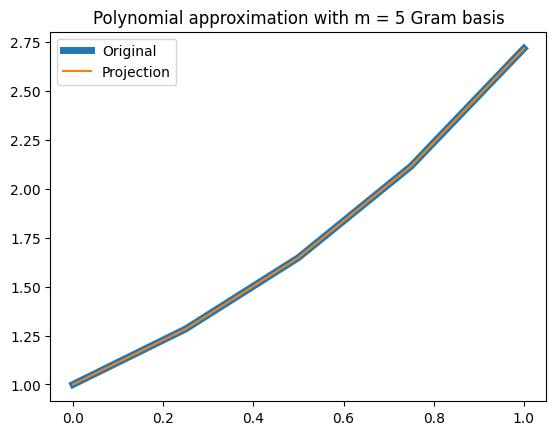

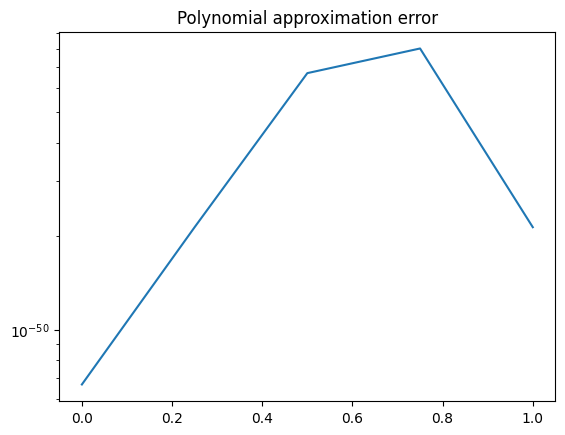

In [66]:
x = mp.linspace(0, 1, 5) 
f = mp.matrix(1, len(x))
for i in range(len(x)):
    f[i] = mp.exp(x[i])
    
m  = 5
gs = GramSchmidt( x, m = m )

coeffs = gs.projectFunction(f) 
frec   = gs.reconstructFunction(coeffs) 

plt.title(f"Polynomial approximation with m = {m} Gram basis")
plt.plot(x, f,    lw = 5,  label="Original")
plt.plot(x, frec,          label="Projection")
plt.legend()
plt.show()
plt.title(f"Polynomial approximation error")
plt.plot(x, np.abs(f - frec))
plt.yscale("log")
plt.show()

### Step 3: Compute FC(SVD) continuations for even and odd pairs of Gram polynomials

In [148]:
M_ALL_K  = 0 
M_EVEN_K = 1
M_ODD_K  = 2 


def t(g, mode = M_ALL_K):
    if g % 2 == 0:
        k = np.arange(-int(-g/2) + 1, int(g/2) + 1)
    else:
        k = np.arange(-int((g-1)/2), int((g-1)/2) + 1)

    if mode == M_EVEN_K:
        k = k[k % 2 == 0]
    elif mode == M_ODD_K:
        k = k[k % 2 == 1]

    return k * mp.mpf(1)
    
def getX(Delta, Gamma):
    dxeval = Delta/(Gamma - 1) 
    xeval  = mp.matrix(1, Gamma) 
    for i in range(Gamma): 
        xeval[0, i] = 1 - Delta + i * dxeval
    return xeval

def getM(g, Gamma, Delta, d, mode): 
    ks = t(g, mode)
    x  = getX(Delta, Gamma) 
    M  = mp.matrix(Gamma, len(ks))
    for i in range(Gamma):
        for j, k in enumerate(ks):
            M[i, j] = mp.exp(1j * k * np.pi / (d + Delta) * x[0, i])
    return M

def invertComplexM(M, cutoff):
    U, s, Vh = mp.svd(M)
    sinv = mp.diag(s) 
    r = M.cols
    if M.rows < M.cols:
        r = M.rows
    for i in range(r):
        if s[i] < cutoff:
            sinv[i, i] = 0
        else:
            sinv[i, i] = 1/s[i]

    Vht = Vh.transpose_conj()
    Ut  = U.transpose_conj()
    f1  = sinv * Ut
    f2  = Vht * f1 
    return  f2

def reconstruct(x, a, g, Gamma, Delta, d, mode): 
    ks = t(g, mode)
    rec = mp.matrix(1, len(x)) 
    for j, coeff in enumerate(a): 
        for i in range(len(x)): 
            rec[i] += coeff * mp.exp(1j * ks[j] * np.pi / (d + Delta) * x[i])
    return rec


def iterativeRefinement(M, Minv, f, threshold = 100, maxiter = 1000):
    a       = Minv * f.T
    r       = M * a - f.T
    counter = 0
    while mp.norm(r) > 2 * eps * mp.norm(a) and counter < maxiter: 
        delta    = Minv * r
        a        = a - delta 
        r        = M * a - f.T
        counter += 1
    return a

def computeExtension(x, g, Gamma, Delta, d, mode, f, threshold = 10, maxiter = 10):
    M     = getM(g, Gamma, Delta, d, mode)
    Minv  = invertComplexM(M, 0) 
    a     = iterativeRefinement(M, Minv, f) 
    frec  = reconstruct(x, a, g, Gamma, Delta, d, mode)
    return frec


In [171]:

m      = 10
n      = 10 
nDelta = 10 
nd     = 27
Gamma  = 150
g      = 63
h      = 1/(nd - 1) 
d      = (nd - 1) * h 
Delta  = (nDelta  - 1) * h 

x = mp.linspace(0, 1, nd)

leftBoundary  = x[       :nDelta]
rightBoundary = x[-nDelta:      ]

lgs = GramSchmidt(leftBoundary, m)
rgs = GramSchmidt(rightBoundary, m)


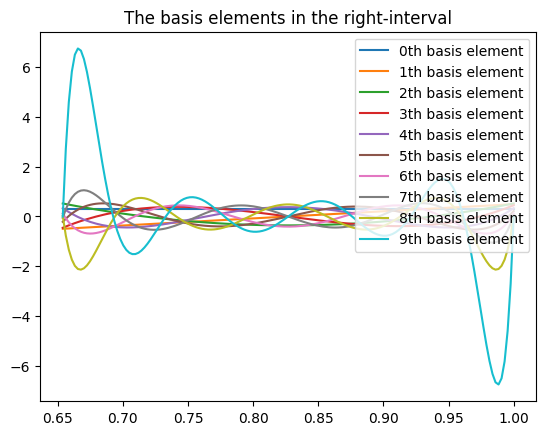

In [172]:
dxeval = Delta/(Gamma - 1) 
xeval  = mp.matrix(1, Gamma) 
for i in range(Gamma): 
    xeval[0, i] = 1 - Delta + i * dxeval

plt.title("The basis elements in the right-interval")
for i in range(m): 
    yeval = rgs.evaluateBasis(xeval, i)
    plt.plot(xeval, yeval, label=f"{i}th basis element") 
plt.legend()
plt.show()


In [173]:
xext  = mp.linspace(1 - Delta, 1 + Delta + 2*d, 1000) 
r     = 10
mode = M_EVEN_K
M     = getM(g, Gamma, Delta, d, mode)
Minv  = invertComplexM(M, 0)
evencoeffs = []
evenbasis = []
evenfrecs = []
for i in range(r): 
    yeval = rgs.evaluateBasis(xeval, i)
    a     = iterativeRefinement(M, Minv, yeval) 
    frec  = reconstruct(xext, a, g, Gamma, Delta, d, mode)
    evencoeffs.append(a) 
    evenbasis.append(yeval)
    evenfrecs.append(frec)


mode = M_ODD_K
M     = getM(g, Gamma, Delta, d, mode)
Minv  = invertComplexM(M, 0)
oddcoeffs = []
oddbasis = []
oddfrecs = []
for i in range(r): 
    yeval = rgs.evaluateBasis(xeval, i)
    a     = iterativeRefinement(M, Minv, yeval) 
    frec  = reconstruct(xext, a, g, Gamma, Delta, d, mode)
    oddcoeffs.append(a) 
    oddbasis.append(yeval)
    oddfrecs.append(frec)

## Reproduce figure 5.2 in Mark Lyon's thesis

Not that $f^3$ has a minus sign compared to the figure on page 38 of his thesis.

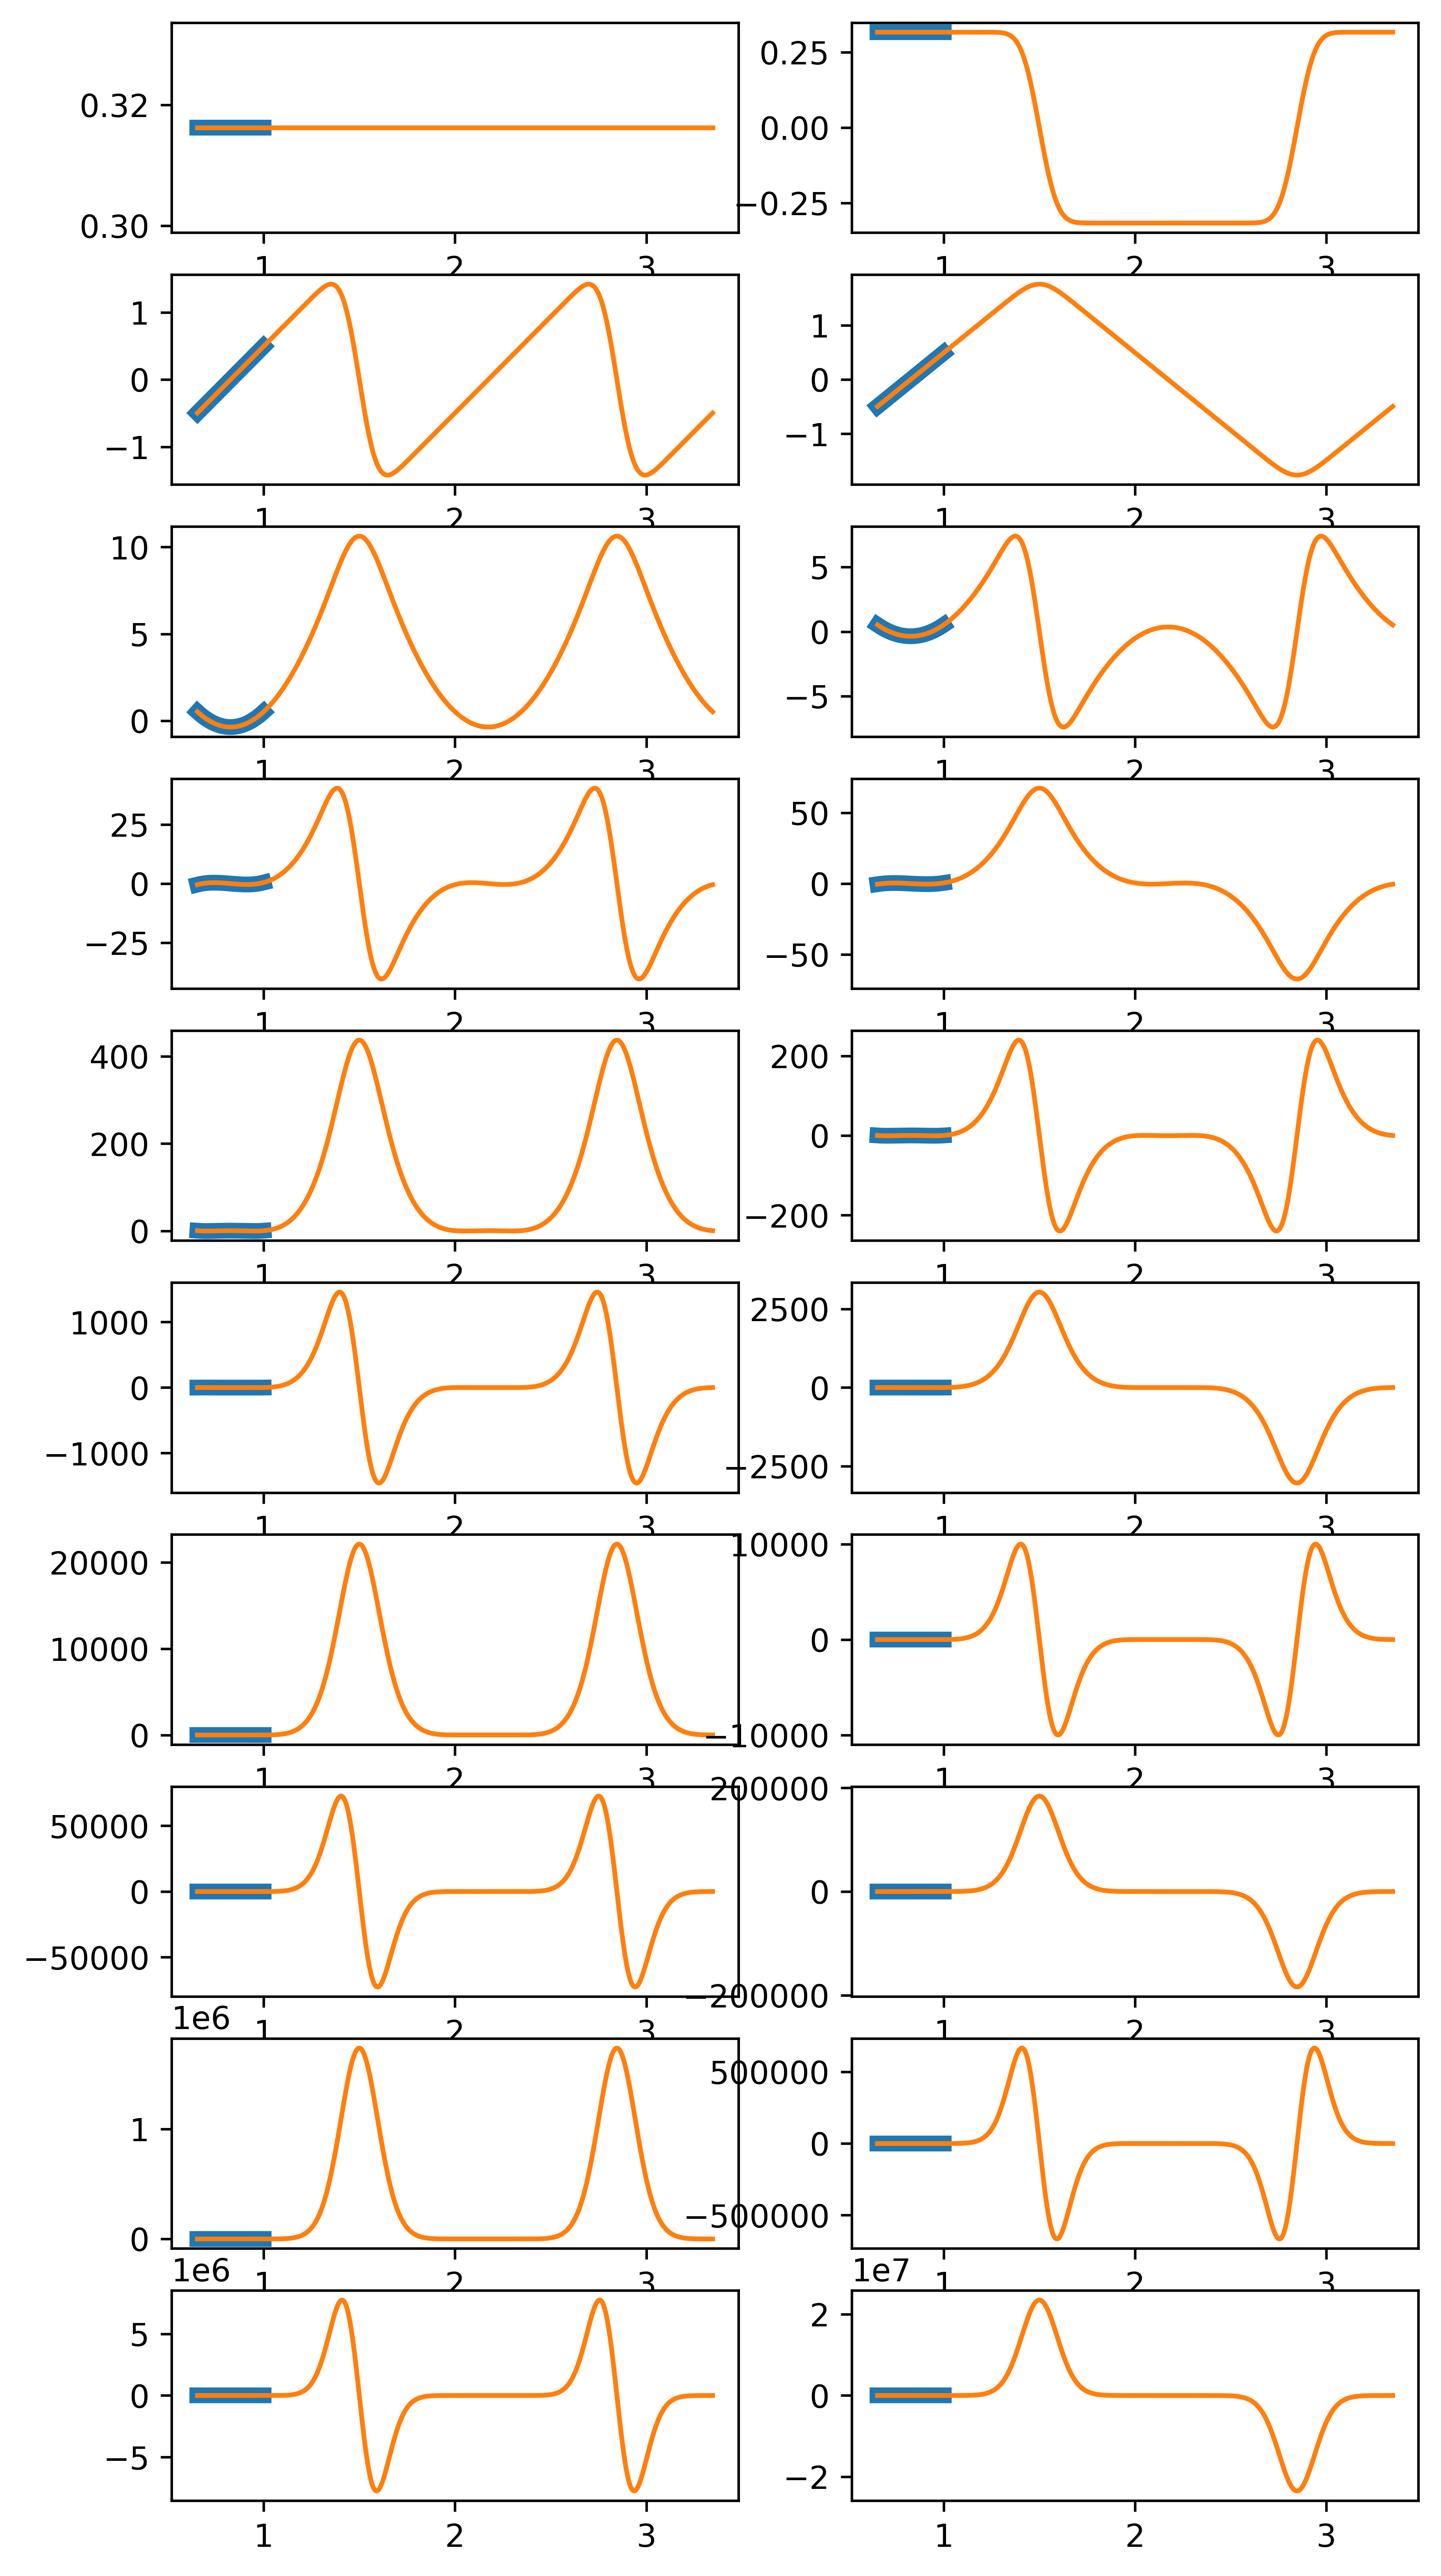

In [174]:
fig, axs = plt.subplots(r, 2, figsize=(3.54*2, 3.54*4), dpi=600) 

for i, (ybasis, yrec) in enumerate(zip(evenbasis, evenfrecs)): 
    axs[i,0].plot(xeval, ybasis, lw = 5)
    y = np.array([mp.re(yrec[i]) for i in range(len(yrec))])
    axs[i,0].plot(xext, y)
for i, (ybasis, yrec) in enumerate(zip(oddbasis, oddfrecs)): 
    axs[i,1].plot(xeval, ybasis, lw = 5)
    y = np.array([mp.re(yrec[i]) for i in range(len(yrec))])
    axs[i,1].plot(xext, y)
plt.show()


## Verify that imaginary parts are zero up to double precision

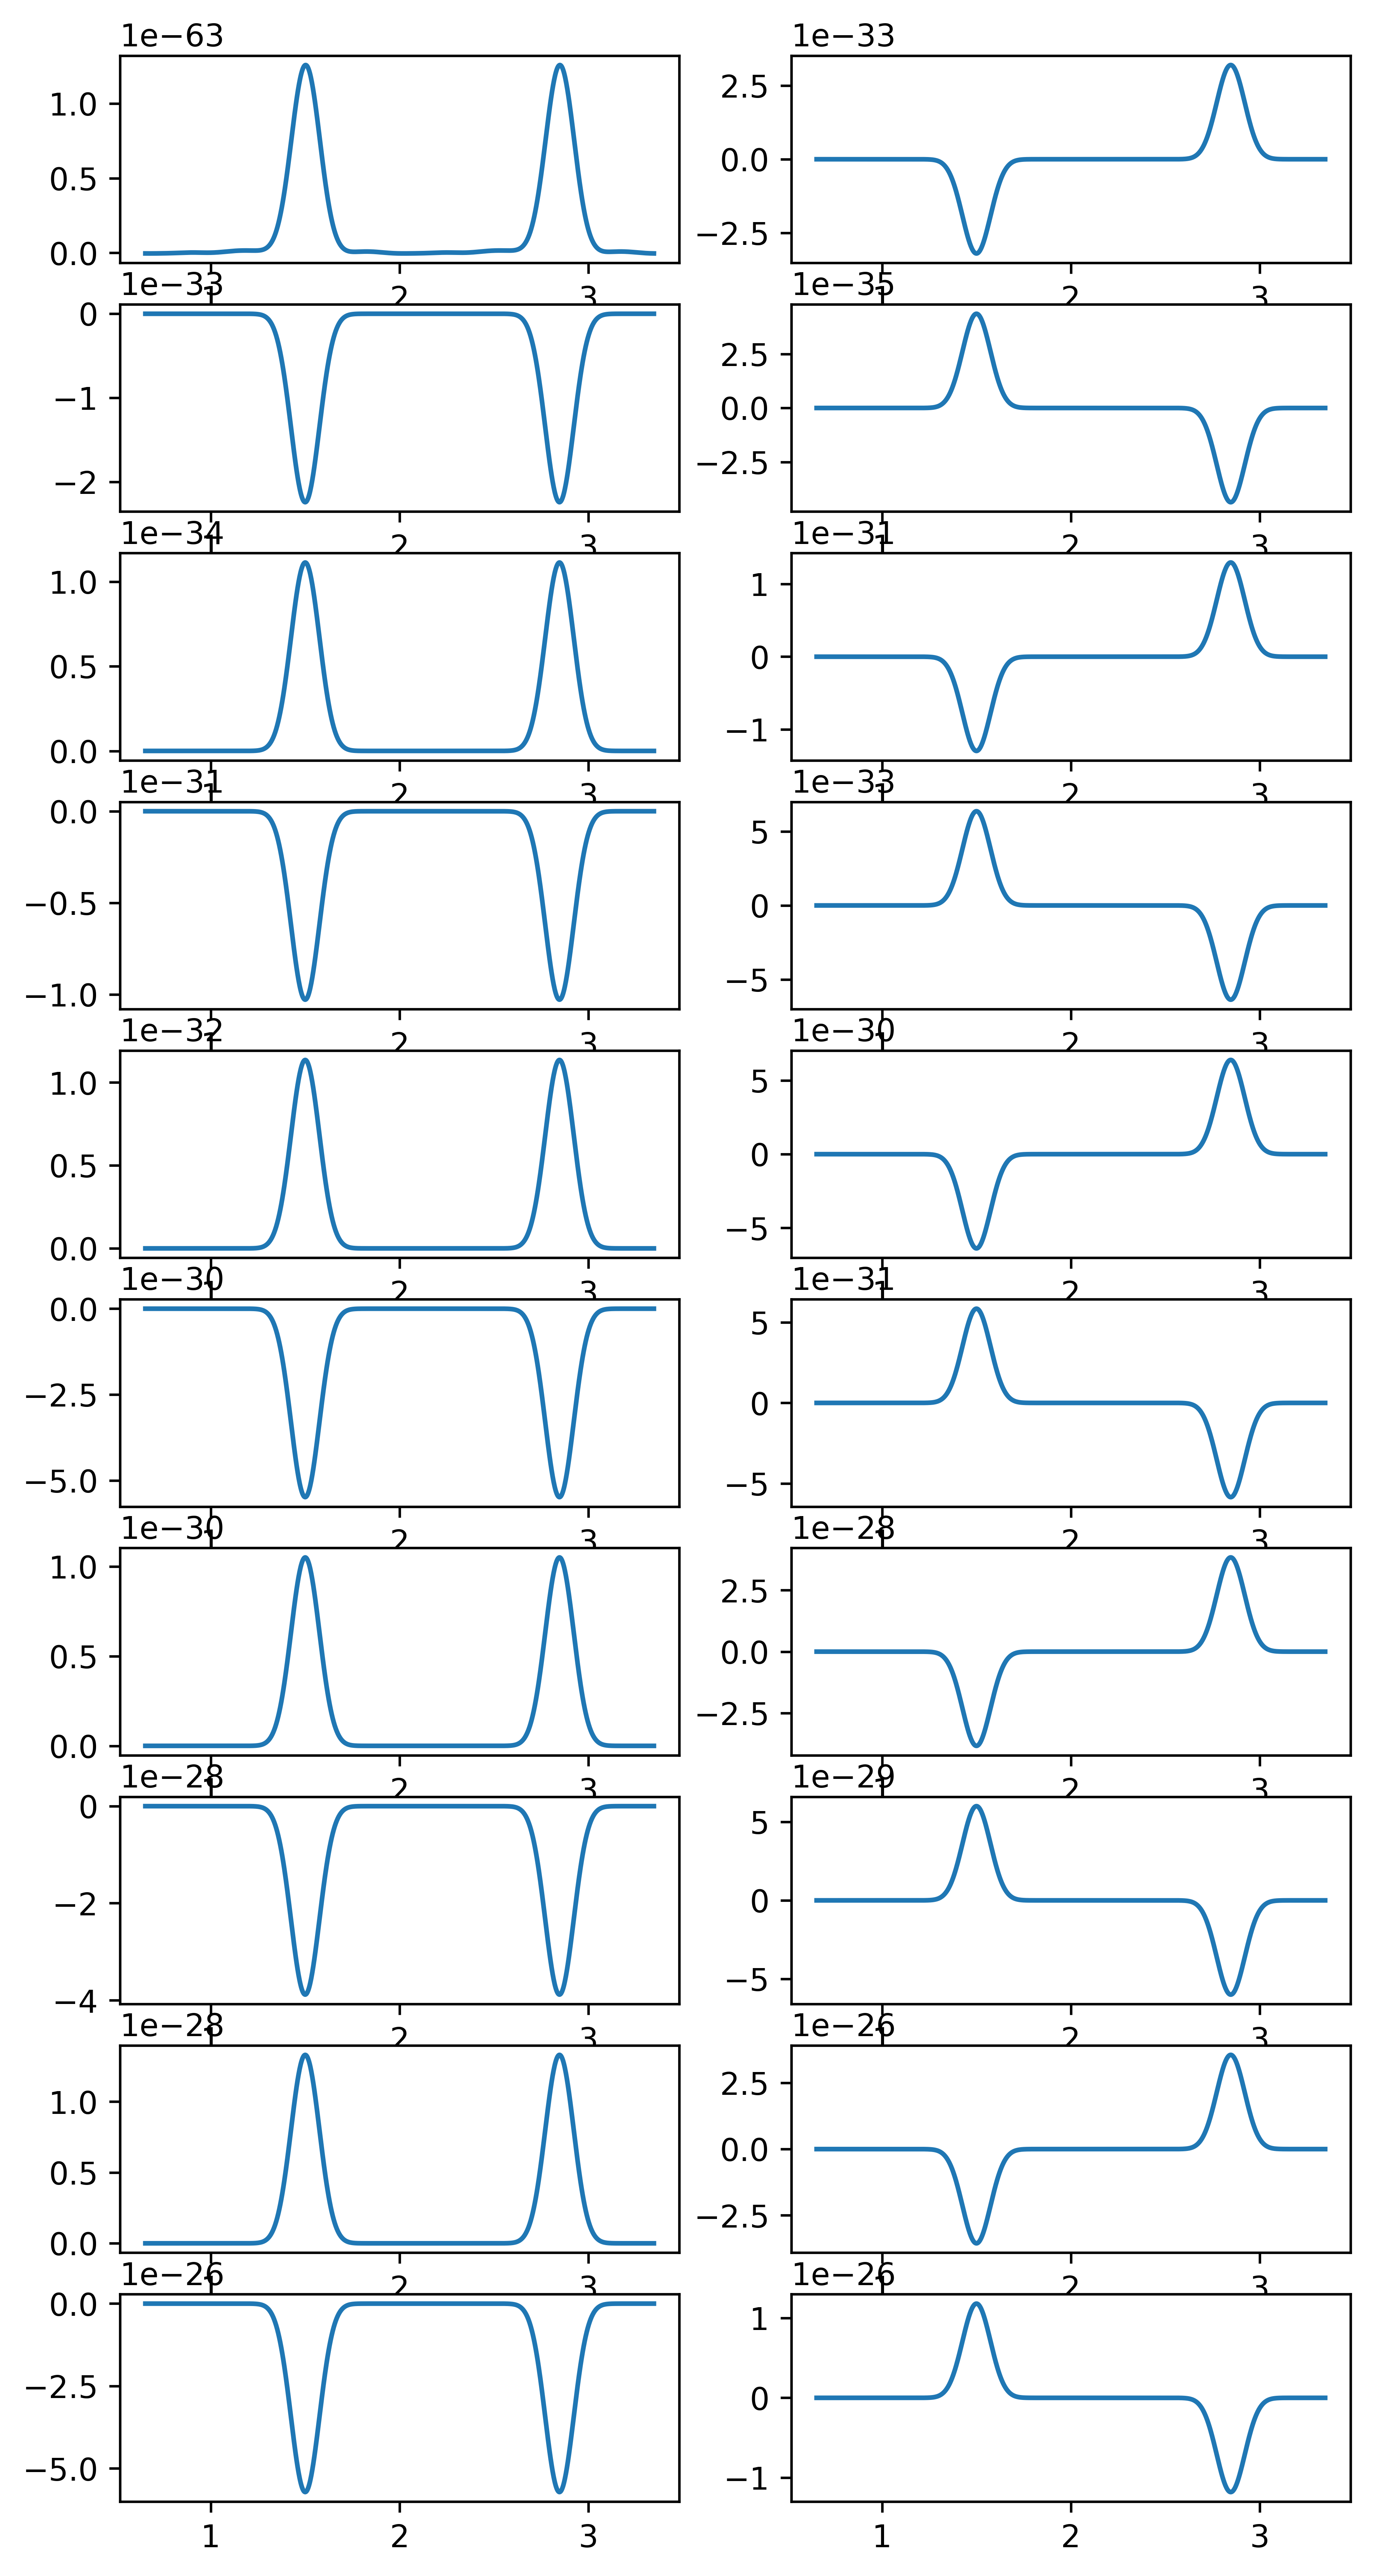

In [175]:
fig, axs = plt.subplots(r, 2, figsize=(3.54*2, 3.54*4), dpi=600) 

for i, (ybasis, yrec) in enumerate(zip(evenbasis, evenfrecs)): 
    y = [mp.im(yrec[i]) for i in range(len(yrec))]
    axs[i,0].plot(xext, y)
for i, (ybasis, yrec) in enumerate(zip(oddbasis, oddfrecs)): 
    y = [mp.im(yrec[i]) for i in range(len(yrec))]
    axs[i,1].plot(xext, y)
plt.show()

## Compute Table 5.2

/tmp/ipykernel_36372/498504990.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(f"Even error {np.float(evenerrors[-1]):1.1e}")


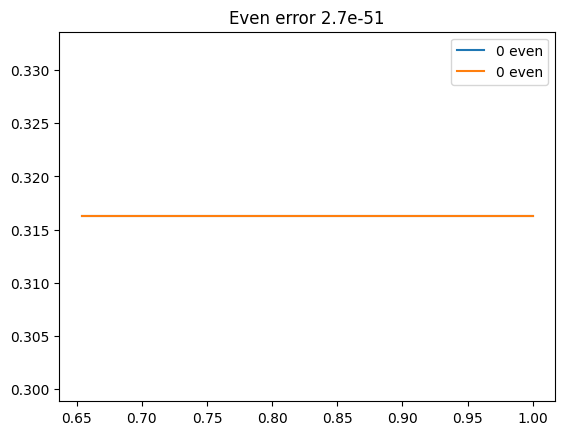

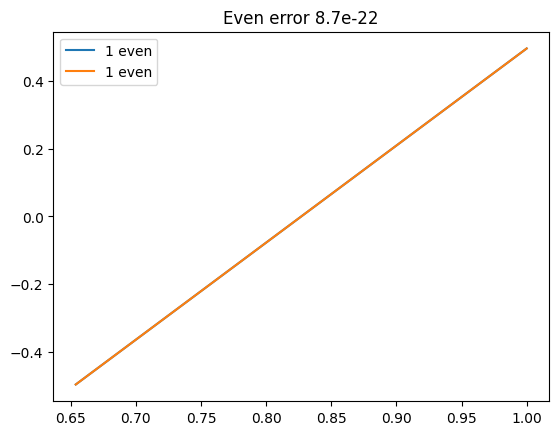

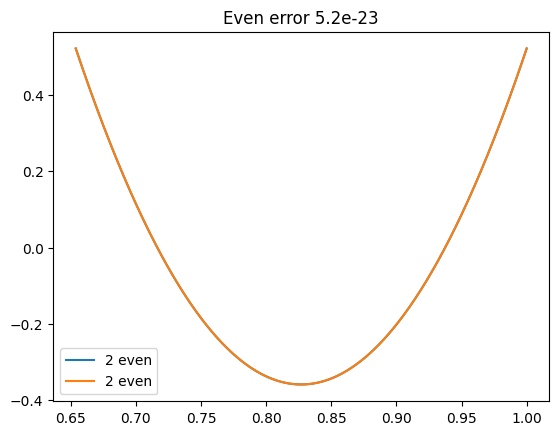

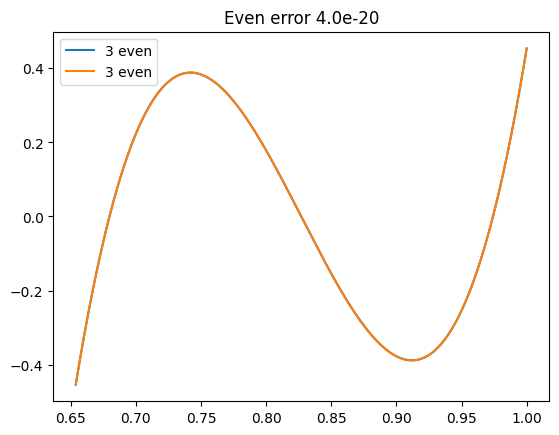

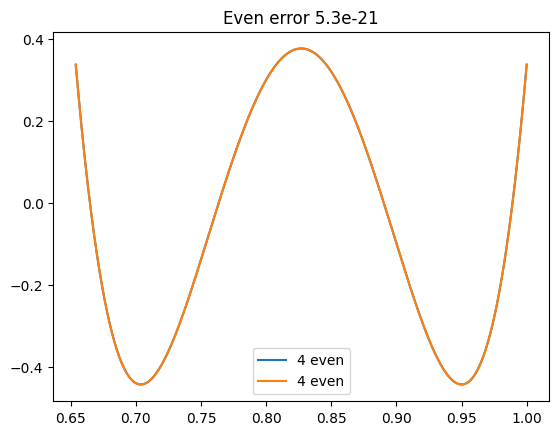

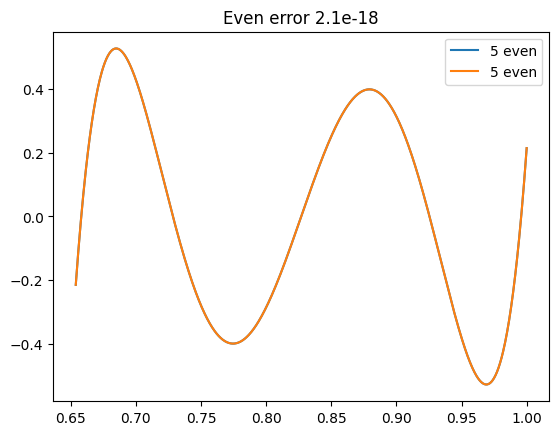

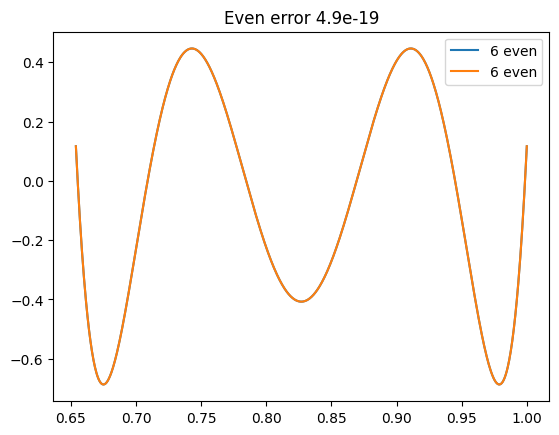

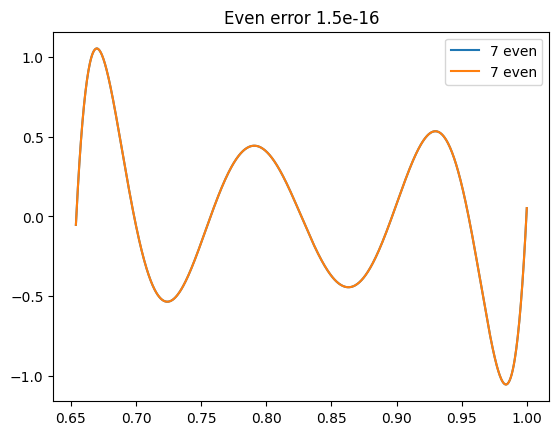

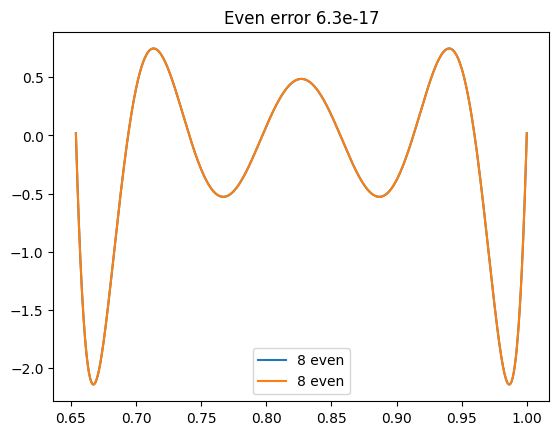

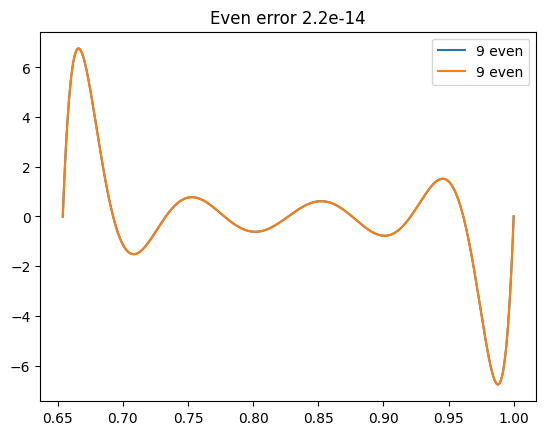

/tmp/ipykernel_36372/498504990.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(f"Odd error {np.float(odderrors[-1]):1.1e}")


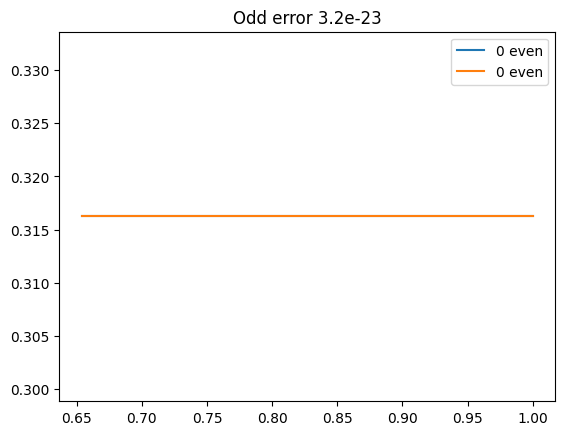

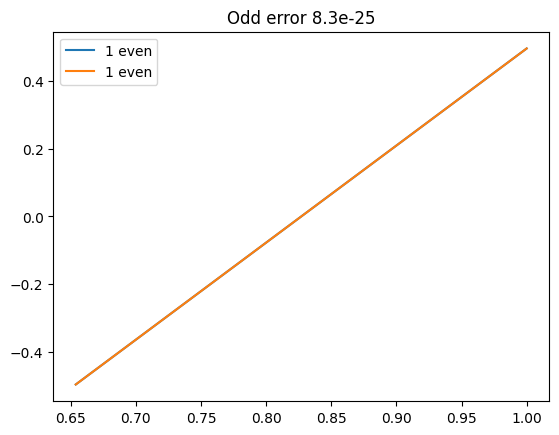

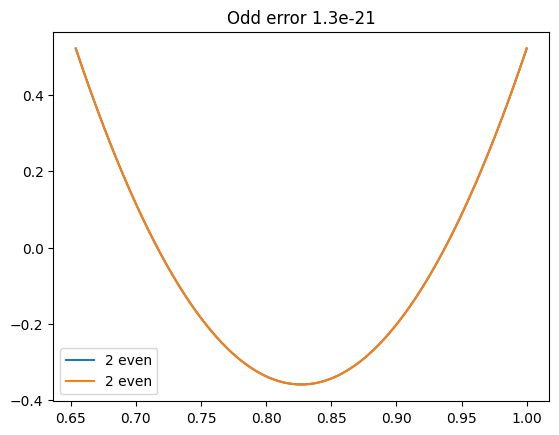

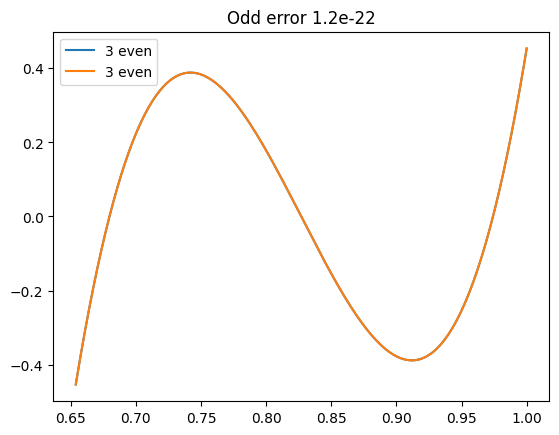

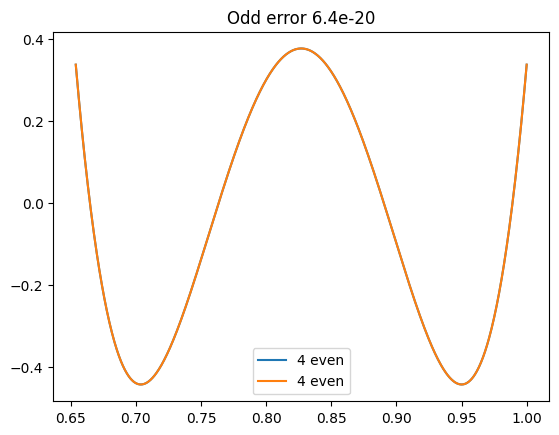

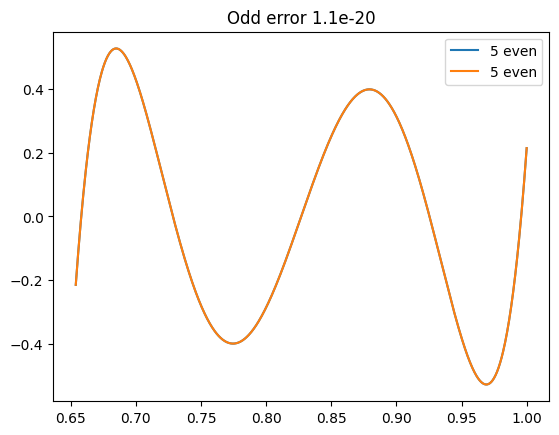

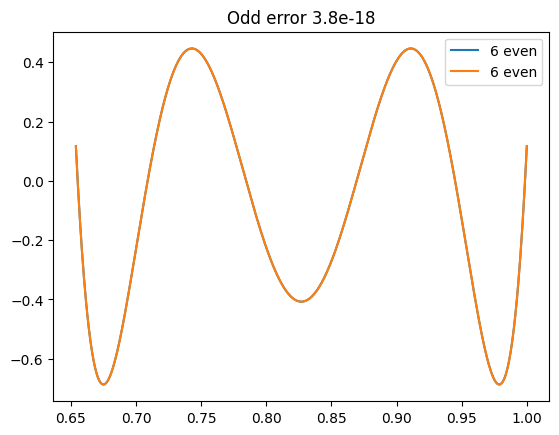

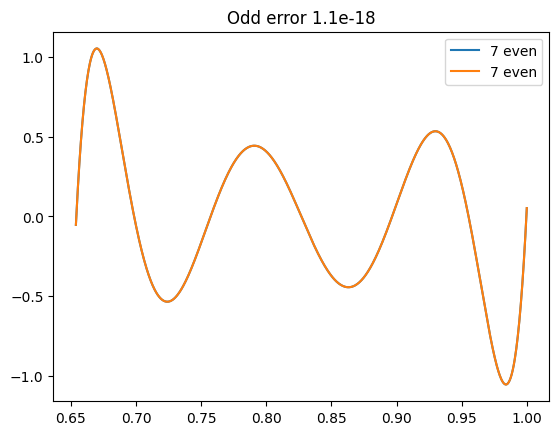

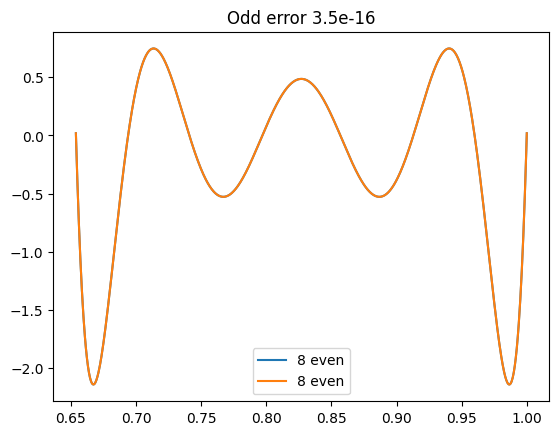

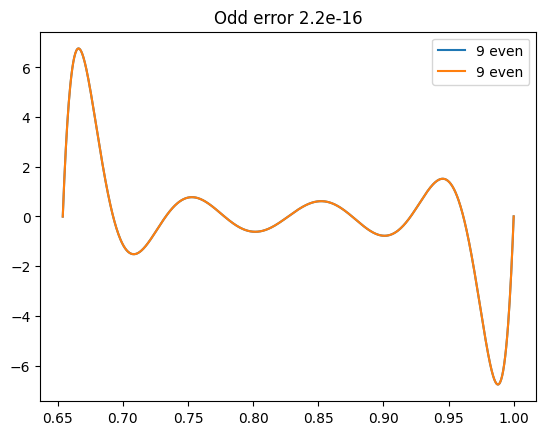

In [187]:
xtest  = mp.linspace(1 - Delta, 1, 900) 
r     = 10
mode = M_EVEN_K
evenerrors = []
for i in range(r): 
    yeval = rgs.evaluateBasis(xtest, i)
    frec  = reconstruct(xtest, evencoeffs[i], g, Gamma, Delta, d, mode)
    y = np.array([mp.re(frec[i]) for i in range(len(frec))])
    evenerrors.append(mp.norm(yeval - frec, p = mp.inf))
    plt.title(f"Even error {np.float(evenerrors[-1]):1.1e}")
    plt.plot(xtest, yeval, label=f"{i} even")
    plt.plot(xtest, y, label=f"{i} even")
    plt.legend()
    plt.show()

mode = M_ODD_K
odderrors = []
for i in range(r): 
    yeval = rgs.evaluateBasis(xtest, i)
    frec  = reconstruct(xtest, oddcoeffs[i], g, Gamma, Delta, d, mode)
    y = np.array([mp.re(frec[i]) for i in range(len(frec))])
    odderrors.append(mp.norm(yeval - frec, p = mp.inf))
    plt.title(f"Odd error {np.float(odderrors[-1]):1.1e}")
    plt.plot(xtest, yeval, label=f"{i} even")
    plt.plot(xtest, y, label=f"{i} even")
    plt.legend()
    plt.show()

Maximum errors (evaluated as maxima over 900 points in the set [1-Delta, 1]) that result from the even and odd continuations of the Gram Polynomials for the parameter values n_Delta = 10, d/Delta = 26/9, g = 63, Gamma = 150. 

In [188]:
for i in range(r): 
    print(f"f{i}_even: {evenerrors[i]} f{i}_odd: {odderrors[i]}")

f0_even: 2.6727647100921956461405364671540571917663360946569e-51 f0_odd: 3.1778606589523135547127464546967460119947499014593e-23
f1_even: 8.6947092748775933515996454635466961926654884045401e-22 f1_odd: 8.2850694572443224745133050296659340387658407009828e-25
f2_even: 5.2418898498912682792960989080701399154051863473254e-23 f2_odd: 1.2876625946372930508698967911182994630296966038014e-21
f3_even: 3.9865167775454459507939533839375684675112328182802e-20 f3_odd: 1.2096456768288655860686846849759303598767355676899e-22
f4_even: 5.3476642434851916070817808141369980891507944392581e-21 f4_odd: 6.3509377410717414584104675635216331747159556164372e-20
f5_even: 2.126875671780560786505433887136335890773372064222e-18 f5_odd: 1.1126652900199211633855755245624300246292934227619e-20
f6_even: 4.9476675423066900329089467358658164631877593136029e-19 f6_odd: 3.8154141665875350698042801781510815887653270634617e-18
f7_even: 1.5068177768461533204259087243538952157447827794782e-16 f7_odd: 1.14227628480512559628887

## Finally store extensions as well as values of Gram basis

In [225]:
xstore = mp.matrix(1, 70)
for i in range(70): 
    xstore[i] = 1 - Delta + i * h

F = mp.matrix(20, 70)

mode = M_EVEN_K

for i in range(r): 
    F[i, :] = reconstruct(xstore, evencoeffs[i], g, Gamma, Delta, d, mode)

mode = M_ODD_K
for i in range(r): 
    F[i+10, :] = reconstruct(xstore, oddcoeffs[i], g, Gamma, Delta, d, mode)

Pr = mp.matrix(10, nDelta)
Pl = mp.matrix(10, nDelta)
for i in range(r): 
    Pr[i, :] = rgs.evaluateBasis(rightBoundary, i)
    Pl[i, :] = lgs.evaluateBasis(leftBoundary, i)

Store everything in double precision in binary files

In [227]:
reF = np.array(F.apply(mp.re), dtype=float).reshape(20, 70)
reF.tofile(f"nD={nDelta}_nd={nd}_g={g}_Gamma={Gamma}.bin")
rePr = np.array(Pr, dtype=float).reshape(10, nDelta) 
rePr.tofile(f"Pright_nD={nDelta}.bin")
rePl = np.array(Pl, dtype=float).reshape(10, nDelta) 
rePl.tofile(f"Pleft_nD={nDelta}.bin")

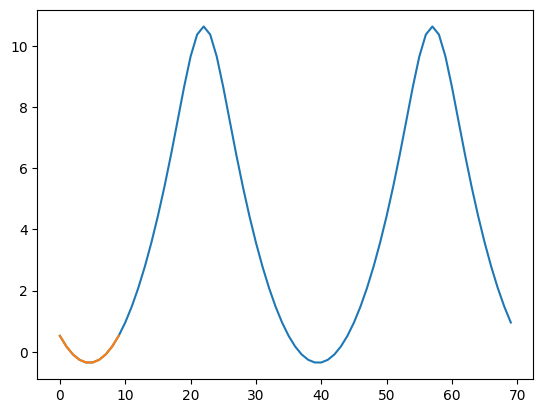

In [232]:
i = 2
plt.plot(reF[i, :])
plt.plot(rePr[i, :])